In [90]:
import torch.nn as nn
import tensorflow as tf
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch
from torchvision import datasets
from torchvision.transforms import transforms
from matplotlib import pyplot as plt
import numpy as np
import torchshow as ts

In [91]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [92]:
train,test=datasets.CIFAR10(root='CIFAR10',download=True,train=True,transform=transform),datasets.CIFAR10(root='CIFAR10',download=True,train=False,transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [93]:
train_loader,test_loader=DataLoader(dataset=train,shuffle=True,batch_size=32),DataLoader(dataset=test,shuffle=True,batch_size=32)

In [94]:
# take a view on our dataset
def show_dataset(dataset_,dataset_labels_):
    # to show labels in convenient format
    cifar_10_labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
    }
    figure = plt.figure(figsize=(6, 6))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        # to pick random images
        sample_idx = tf.random.uniform(shape=(1,), minval=0, maxval=len(dataset_), dtype=tf.int64).numpy()[0]
        # retrieve image name and it's labels
        img, label = dataset_[sample_idx],cifar_10_labels[dataset_labels_[sample_idx]]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

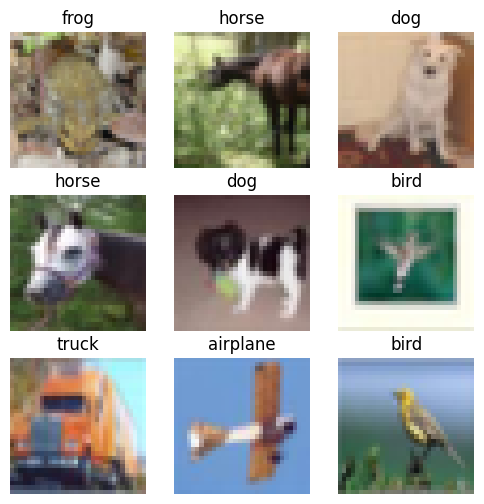

In [95]:
show_dataset(train.data,train.targets)

In [96]:
# # Let's write our model structure 
# # input 32x32x3 -> 3072 -> 256 -> 128 -> 64 -> 32 -> 16   This is encoder
# # 16 -> 32 -> 64 -> 128 -> 256 -> 3072 -> 32x32x3             This is decoder
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.encoder=nn.Sequential(
            nn.Linear(32 * 32 * 3,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.Tanh(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,8),
        )
        self.decoder=nn.Sequential(
            nn.Linear(8,16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.Tanh(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,3 * 32 * 32),
        )

    def forward(self, x):
        x=x.view(-1, 32 * 32 * 3)
        # Encoder
        encoded = self.encoder(x)
        # Decoder
        decoded = self.decoder(encoded)
        # Reshape back to image dimensions
        decoded = decoded.view(-1, 3, 32, 32)
        return decoded

In [97]:
model1=Model()
model1

Model(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=3072, bias=True)
  )
)

In [98]:
def training_process(loader, my_model, optimize, loss):
    # Turn on the training mode
    my_model.train()
    loss_val=0
    for i, (images, labels) in tqdm(enumerate(loader), total=len(loader)):
        # Gradients are reset to zero
        optimize.zero_grad()
        # Forward pass
        reconstructed = my_model(images)
        # Compute the loss
        loss_val = loss(reconstructed, images)
        # Backward pass
        loss_val.backward()
        # Update the weights
        optimize.step()
    return float(loss_val)

In [99]:
def evaluating_perfomance(loader_test,my_model,loss):
        with torch.no_grad():
        # no updating weights
            for images,labels in loader_test:
                reconstructed = my_model(images)
                # compute loss on test dataset
                loss_val=loss(reconstructed,images)
        return float(loss_val)

In [100]:
def plot_loss(loss,label,epochs):
    plt.title(label)
    plt.plot(loss)
    plt.grid()
    plt.xticks(np.arange(epochs))
def plot_losses(train_loss,testing_loss,epochs):
    plt.figure(figsize=(13,5))
    plt.subplot(1,2,1)
    plot_loss(train_loss,label=f'Train loss: {train_loss[-1]}',epochs=epochs)
    plt.subplot(1,2,2)
    plot_loss(train_loss,label=f'Test loss: {testing_loss[-1]}',epochs=epochs)
    plt.show()

In [101]:
def show_decoded_images(model_,test_data,samples):
    model_.eval()
    decoded_images=[]
    fig, axs = plt.subplots(2, samples, figsize=(15, 5))
    with torch.no_grad():
        random_image_indexes=list(np.random.randint(0,len(test_data),samples))
        original_images=[test_data[i][0] for i in random_image_indexes]
        for i in original_images:
            decoded_images.append(model_(i))
        print('Original Images:')
        for i in range(samples):
            img=np.transpose(original_images[i], (1, 2, 0))
            axs[0][i].imshow(img)
            axs[0][i].axis('off')
        print('Decoded Images:')
        for i in range(samples):
            if decoded_images[i].shape==torch.Size([1, 3, 32, 32]):
                img = np.transpose(decoded_images[i][0], (1, 2, 0))
            else:
                img = np.transpose(decoded_images[i], (1, 2, 0))
            axs[1][i].imshow(img)
            axs[1][i].axis('off')

In [102]:
def run_epochs(model_type,epochs,loss_func):
    # to track loss and accuracy after each epoch
    train_loss,testing_loss=[],[]
    for epoch in range(1,epochs+1):
            print(f"Epoch number: {epoch}")
            print()
            print('Training..')
            loss_=training_process(loader=train_loader,my_model=model_type,optimize=optimizer,loss=loss_func)
            train_loss.append(loss_)
            print(f'Training_Loss: {train_loss[-1]}')
            print('Testing..')
            loss_test=evaluating_perfomance(loader_test=test_loader,my_model=model_type,loss=loss_func)
            testing_loss.append(loss_test)
            print(f'Testing_Loss: {testing_loss[-1]}')
            # if it is the last epoch -> show graphs and images
            if epoch==epochs:
                show_decoded_images(model_type,test_data=test_loader.dataset,samples=8)
                plot_losses(train_loss,np.array(testing_loss),epochs)

In [103]:
# define hyperparameters
epochs=15
loss_func=nn.MSELoss()
optimizer=torch.optim.Adam(model1.parameters(),lr=0.001)  

Epoch number: 1

Training..


100%|██████████| 1563/1563 [00:07<00:00, 205.84it/s]


Training_Loss: 0.031748365610837936
Testing..
Testing_Loss: 0.03431044891476631
Epoch number: 2

Training..


100%|██████████| 1563/1563 [00:08<00:00, 191.86it/s]


Training_Loss: 0.03510664030909538
Testing..
Testing_Loss: 0.026027262210845947
Epoch number: 3

Training..


100%|██████████| 1563/1563 [00:08<00:00, 185.54it/s]


Training_Loss: 0.030503293499350548
Testing..
Testing_Loss: 0.03286345675587654
Epoch number: 4

Training..


100%|██████████| 1563/1563 [00:08<00:00, 184.75it/s]


Training_Loss: 0.03095111809670925
Testing..
Testing_Loss: 0.0350656695663929
Epoch number: 5

Training..


100%|██████████| 1563/1563 [00:08<00:00, 186.03it/s]


Training_Loss: 0.027385609224438667
Testing..
Testing_Loss: 0.02625107951462269
Epoch number: 6

Training..


100%|██████████| 1563/1563 [00:08<00:00, 182.90it/s]


Training_Loss: 0.02453010343015194
Testing..
Testing_Loss: 0.02565794251859188
Epoch number: 7

Training..


100%|██████████| 1563/1563 [00:08<00:00, 182.79it/s]


Training_Loss: 0.0315612331032753
Testing..
Testing_Loss: 0.029823848977684975
Epoch number: 8

Training..


100%|██████████| 1563/1563 [00:08<00:00, 183.33it/s]


Training_Loss: 0.026852922514081
Testing..
Testing_Loss: 0.022842034697532654
Epoch number: 9

Training..


100%|██████████| 1563/1563 [00:08<00:00, 182.16it/s]


Training_Loss: 0.025359081104397774
Testing..
Testing_Loss: 0.027699826285243034
Epoch number: 10

Training..


100%|██████████| 1563/1563 [00:08<00:00, 182.57it/s]


Training_Loss: 0.021909939125180244
Testing..
Testing_Loss: 0.022757207974791527
Epoch number: 11

Training..


100%|██████████| 1563/1563 [00:08<00:00, 183.09it/s]


Training_Loss: 0.02439696528017521
Testing..
Testing_Loss: 0.02373368851840496
Epoch number: 12

Training..


100%|██████████| 1563/1563 [00:08<00:00, 182.98it/s]


Training_Loss: 0.02244909293949604
Testing..
Testing_Loss: 0.026429690420627594
Epoch number: 13

Training..


100%|██████████| 1563/1563 [00:08<00:00, 181.60it/s]


Training_Loss: 0.020019054412841797
Testing..
Testing_Loss: 0.025779562070965767
Epoch number: 14

Training..


100%|██████████| 1563/1563 [00:08<00:00, 182.91it/s]


Training_Loss: 0.02376696653664112
Testing..
Testing_Loss: 0.023077866062521935
Epoch number: 15

Training..


100%|██████████| 1563/1563 [00:08<00:00, 182.83it/s]


Training_Loss: 0.01886543445289135
Testing..


Testing_Loss: 0.027772316709160805
Original Images:
Decoded Images:


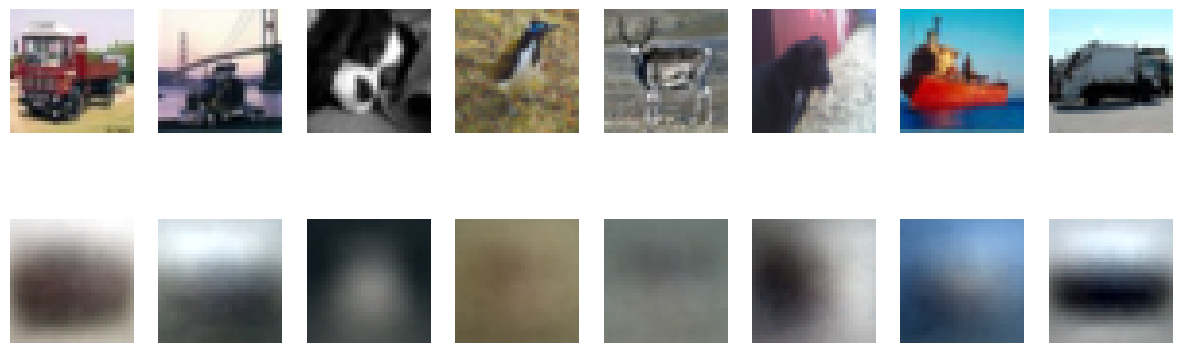

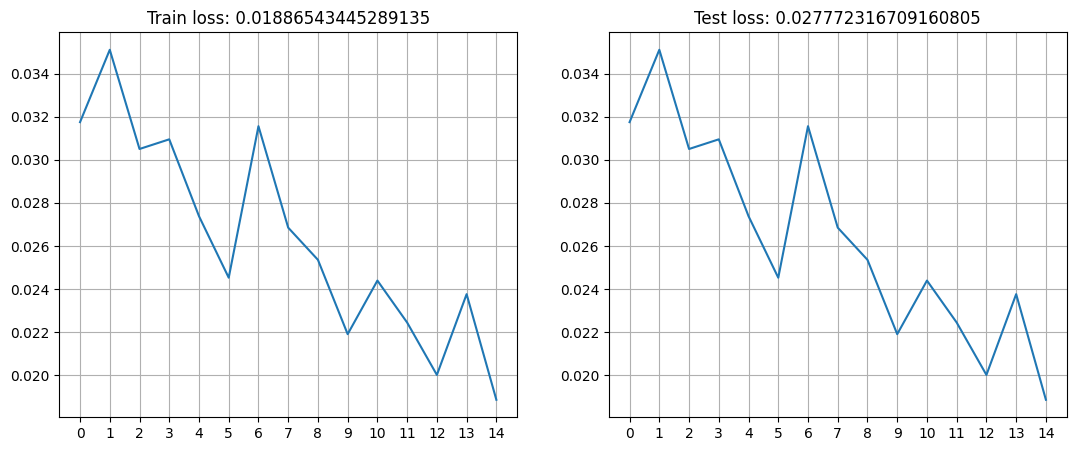

In [104]:
run_epochs(model_type=model1,epochs=epochs,loss_func=loss_func)

In [113]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),        
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            # ConvTranspose -> like Conv2d but they are used in decoding (deconvolutions)
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [114]:
model2=Model()
model2

Model(
  (encoder): Sequential(
    (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)

In [115]:
# define hyperparameters
epochs=18
loss_func=nn.MSELoss()
optimizer=torch.optim.Adam(model2.parameters(),lr=0.001)  

Epoch number: 1

Training..


100%|██████████| 1563/1563 [00:48<00:00, 31.98it/s]


Training_Loss: 0.006124748382717371
Testing..
Testing_Loss: 0.006531981285661459
Epoch number: 2

Training..


100%|██████████| 1563/1563 [00:51<00:00, 30.31it/s]


Training_Loss: 0.004704390186816454
Testing..
Testing_Loss: 0.005385920871049166
Epoch number: 3

Training..


100%|██████████| 1563/1563 [00:46<00:00, 33.30it/s]


Training_Loss: 0.004141025245189667
Testing..
Testing_Loss: 0.004349441267549992
Epoch number: 4

Training..


100%|██████████| 1563/1563 [00:46<00:00, 33.90it/s]


Training_Loss: 0.0035009554121643305
Testing..
Testing_Loss: 0.002875733422115445
Epoch number: 5

Training..


100%|██████████| 1563/1563 [00:45<00:00, 34.15it/s]


Training_Loss: 0.003270289860665798
Testing..
Testing_Loss: 0.0029450927395373583
Epoch number: 6

Training..


100%|██████████| 1563/1563 [00:45<00:00, 34.11it/s]


Training_Loss: 0.0025650199968367815
Testing..
Testing_Loss: 0.003249505767598748
Epoch number: 7

Training..


100%|██████████| 1563/1563 [00:46<00:00, 33.90it/s]


Training_Loss: 0.003459873842075467
Testing..
Testing_Loss: 0.0037517875898629427
Epoch number: 8

Training..


100%|██████████| 1563/1563 [00:46<00:00, 33.96it/s]


Training_Loss: 0.0027855520602315664
Testing..
Testing_Loss: 0.0028419846203178167
Epoch number: 9

Training..


100%|██████████| 1563/1563 [00:45<00:00, 33.98it/s]


Training_Loss: 0.0019147060811519623
Testing..
Testing_Loss: 0.0020523217972368
Epoch number: 10

Training..


100%|██████████| 1563/1563 [00:45<00:00, 34.20it/s]


Training_Loss: 0.0024412719067186117
Testing..
Testing_Loss: 0.001905048848129809
Epoch number: 11

Training..


100%|██████████| 1563/1563 [00:46<00:00, 33.95it/s]


Training_Loss: 0.0023192125372588634
Testing..
Testing_Loss: 0.00199181423522532
Epoch number: 12

Training..


100%|██████████| 1563/1563 [00:45<00:00, 34.02it/s]


Training_Loss: 0.0017561349086463451
Testing..
Testing_Loss: 0.001564884907566011
Epoch number: 13

Training..


100%|██████████| 1563/1563 [00:45<00:00, 34.16it/s]


Training_Loss: 0.0015952630201354623
Testing..
Testing_Loss: 0.0022500057239085436
Epoch number: 14

Training..


100%|██████████| 1563/1563 [00:45<00:00, 34.17it/s]


Training_Loss: 0.0019364799372851849
Testing..
Testing_Loss: 0.0016917865723371506
Epoch number: 15

Training..


100%|██████████| 1563/1563 [00:45<00:00, 34.04it/s]


Training_Loss: 0.001598281436599791
Testing..
Testing_Loss: 0.0011241298634558916
Epoch number: 16

Training..


100%|██████████| 1563/1563 [00:46<00:00, 33.95it/s]


Training_Loss: 0.0016560988733544946
Testing..
Testing_Loss: 0.0021253274753689766
Epoch number: 17

Training..


100%|██████████| 1563/1563 [00:45<00:00, 34.06it/s]


Training_Loss: 0.0019468003883957863
Testing..
Testing_Loss: 0.001640297588892281
Epoch number: 18

Training..


100%|██████████| 1563/1563 [00:45<00:00, 34.03it/s]


Training_Loss: 0.0014569563791155815
Testing..
Testing_Loss: 0.0017629795474931598
Original Images:
Decoded Images:


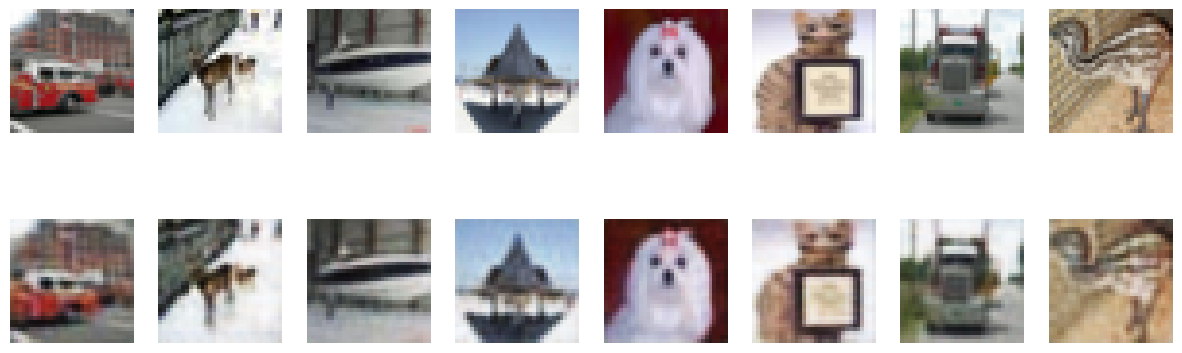

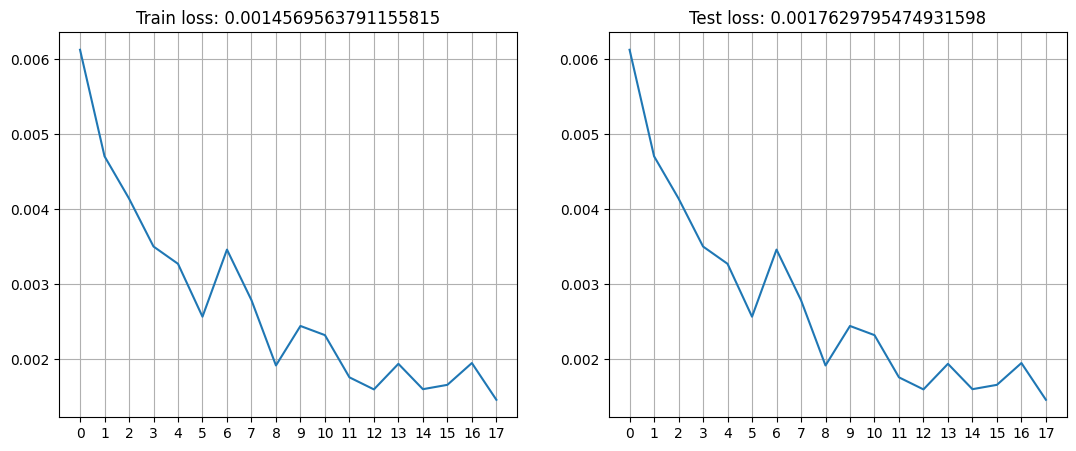

In [116]:
run_epochs(model_type=model2,epochs=epochs,loss_func=loss_func)